# TP1 Recursive Least Squares


Integrantes:

- Ian C. Diaz
- Mastín S. Rodriguez Turco
- Agustín Galdeman 

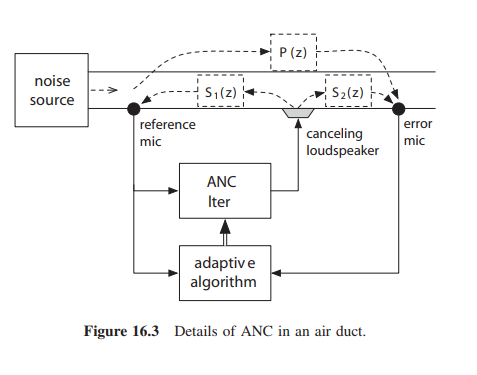

## Imports de librerias

In [1]:
!pip install pyroomacoustics

     |████████████████████████████████| 1.1MB 5.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached https://files.pythonhosted.org/packages/00/84/fc9dc13ee536ba5e6b8fd10ce368fea5b738fe394c3b296cde7c9b144a92/pybind11-2.6.1-py2.py3-none-any.whl
  Created wheel for pyroomacoustics: filename=pyroomacoustics-0.4.2-cp36-cp36m-linux_x86_64.whl size=9535662 sha256=cdef439945acacc8a6486cdd00d024e0a6d5ab8eb0d22e4a208b2c386d649c24
  Stored in directory: /root/.cache/pip/wheels/a8/36/c1/e2c6c0c9a018975e20f7c4694ee1d19f768ac7b3aba168231a
Successfully built pyroomacoustics


In [2]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.io.wavfile as wav
from IPython.display import Audio
import pyroomacoustics as pra #hay que instalar

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Definición de clases


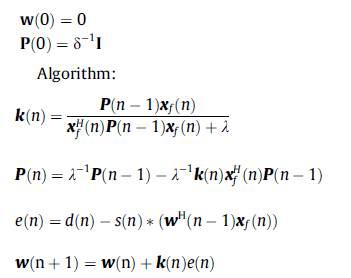

In [4]:
class RLS:
	def __init__(self, N,lam, delta):
		"""
		Funcion de inicialización del algoritmo RLS
		:param lam: lambda del algoritmo RLS
		:param delta: Delta del algoritmo de RLS, positivo y pequeña para alto SNR
		o positivo y grande para bajo SNR.
		"""
		self.lam = lam
		self.delta = delta
		self.w = np.zeros((N,1))
		self.P = np.power(delta,-1) * np.eye(N)
		self.N = N
		return

	def calcNewCoef(self, u, d):
		"""
		Funcion que dados unos coeficientes previos, los actualiza correspondientemente
		:param u: vector columna con las N entradas (pej u = np.zeros((N,1)))
		:param d: tap de señal deseada
		"""
		P_n_1 = self.P ##+ np.random.randn(self.N, self.N) / 10
		w_n_1 = self.w

		k_n = (np.matmul(P_n_1, u)) / (self.lam + np.matmul(np.transpose(u),np.matmul(P_n_1, u)))
		e_n = d - np.dot(np.transpose(w_n_1), u)
		##
		temp1 = np.matmul(np.transpose(u), P_n_1)
		#print("################")
		#print(np.transpose(np.atleast_2d(k_n)).shape)
		#print(np.atleast_2d(temp1).shape)
		temp2 = np.matmul(np.transpose(np.atleast_2d(k_n)), np.atleast_2d(temp1))
		#print(temp2.shape)
		self.P =  np.power(self.lam,-1) * P_n_1 - np.power(self.lam,-1) * temp2
		##
		self.w = np.transpose(np.transpose(w_n_1) + k_n * np.conjugate(e_n))
		return self.w

	def calcNewCoefFX(self,u,e_n):
		"""
		Funcion que dados unos coeficientes previos, los actualiza correspondientemente
		:param u: vector columna con las N entradas (pej u = np.zeros((N,1)))
		:param d: tap de señal deseada
		"""
		P_n_1 = self.P ##+ np.random.randn(self.N, self.N) / 10
		w_n_1 = self.w

		k_n = (np.matmul(P_n_1, u)) / (self.lam + np.matmul(np.transpose(u),np.matmul(P_n_1, u)))
		##
		temp1 = np.matmul(np.transpose(u), P_n_1)
		#print("################")
		#print(np.transpose(np.atleast_2d(k_n)).shape)
		#print(np.atleast_2d(temp1).shape)
		temp2 = np.matmul(np.transpose(np.atleast_2d(k_n)), np.atleast_2d(temp1))
		#print(temp2.shape)
		self.P =  np.power(self.lam,-1) * P_n_1 - np.power(self.lam,-1) * temp2
		##
		self.w = np.transpose(np.transpose(w_n_1) + k_n * np.conjugate(e_n))
		return self.w
	
	def getCoefs(self):
		return self.w
	

In [5]:
class AdaptativeFilterRLS:
	def __init__(self, N= 60, lam= 0.87, delta= 0.5):
		"""
		Funcion de inicializacion del filtro adaptativo
		@:param N: Es el orden del filtro
		"""
		self.N = N
		self.rls = RLS(N,lam,delta)
		return

	def fit(self, input, desired):
		"""
		Funcion que actualiza los pesos de un filtro adaptativo para que se ajusten a la respuesta deseada.
		@:param input: Vector de entrada al filtro adaptativo
		@:param desired: Vector de señal deseada del filtro adaptativo.
		"""
		error = []
		w_list = []
		out_list = []
		for i in tqdm(range(len(input)-self.N)):
			inp = input[i:self.N+i]
			des = desired[i:self.N+i]

			coefs = self.rls.calcNewCoef(np.flip(inp),des[-1]);

			output = np.dot(inp, np.flip(coefs))
			out_list.append(np.array(output).flatten())
			error.append(des[-1] - output)
			w_list.append(self.rls.getCoefs())
		return error, np.array(w_list), out_list

	def fitFXRLS(self, input_prim, e_tap):
		self.rls.calcNewCoefFX(np.flip(input_prim),e_tap)
		return 

	def getFilterParameters(self):
		"""
		Función que devuelve los parámetros del filtro adaptativo
		"""
		return self.rls.getCoefs()

	def applyFilterFull(self, input):
		"""
		Aplica el filtro adaptativo obtenido a un vector de entrada
		@:param input: vector de entrada para aplicar el filtro. (IMPORTANTE: No actualiza self.inp_signal)
		@:return Vector de salida del filtro.
		"""
		return signal.convolve(input, np.flip(self.rls.getCoefs()).flatten(), mode="full")


In [6]:
class Filter:
	def __init__(self,coefs):
		"""
		Funcion para inicializar el filtro con una lista de coeficientes dada
		:param coefs: Coeficientes del filtro a inicializar deben estar dados de la siguiente manera:
			[w0,w1,w2,w3,..wN]
		"""
		self.coefs = coefs
		return

	def applyFilter(self, input):
		"""
		Funcion para aplicar el filtro a una señal de entrada dada
		:param input: Vector de señal de entrada, con el valor mas reciente ubicado a derecha, y el valor mas viejo a
		izquierda.
		:return: Vector de la señal de salida, filtrada.
		"""
		return signal.convolve(input, self.coefs, mode="full")

	def getFilterLen(self):
		"""
		Funcion que devuelve la cantidad de parámetros del filtro.
		:return:
		"""
		return len(self.coefs)

	def getCoefs(self):
		"""
		Funcion que devuelve una lista con los coeficientes del filtro.
		:return: Lista con los coeficientes del filtro.
		"""
		return self.coefs

## Simulación


Definición de los Filtros $S_2$ y $P$

Definición del filtro $S_2$

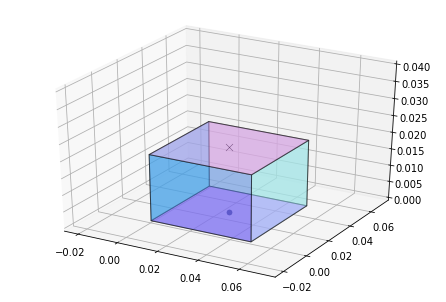

In [7]:
#fs, signal = wav.read("/content/o_white.wav")
x = np.random.randn(999999)
fs = 48e3
m = pra.make_materials(ceiling=0.3,
                       floor=0.3,
                       east=0.8,
                       west=0.8,
                       north=0.8,
                       south=0.8,)

room_dim = [0.05, 0.05, 0.02]
room = pra.ShoeBox(room_dim, fs=fs, materials=m, air_absorption=True, ray_tracing=True)

#set_raytracing
room.add_source([0.025, 0.025, 1e-4], signal=x)
mike = np.array([0.025, 0.025, 0.02-1e-4])
room.add_microphone(mike)
fig, ax = room.plot(mic_marker_size=50)
ax.set_xlim([-0.025, 0.025 + 0.05])
ax.set_ylim([-0.025, 0.025 + 0.05])
ax.set_zlim([0, 0.04])
plt.show()

#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)
room.image_source_model()

room.compute_rir()
response = room.rir[0][0] #respuesta impulsiva
#print(room.rir[0][0])
#print(len(room.rir[0][0]))

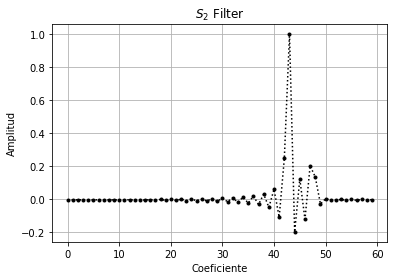

In [8]:
s2 = Filter(list(response[:60]/np.max(response)))
plt.plot(range(60),response[:60]/np.max(response), color= "black", marker='.', linestyle= ':')
plt.xlabel("Coeficiente")
plt.ylabel("Amplitud")
plt.title("$S_2$ Filter")
plt.grid(which= "both")

Definición del filtro $P$

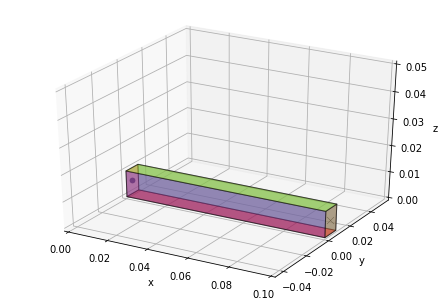

In [9]:
x = np.random.randn(999999)
fs = 48e3
m = pra.make_materials(ceiling=0.3,
                       floor=0.3,
                       east=0.8,
                       west=0.8,
                       north=0.8,
                       south=0.8,)

room_dim = [0.1, 0.01, 0.01]
room = pra.ShoeBox(room_dim, fs=fs, materials=m, air_absorption=True, ray_tracing=True)

#set_raytracing
room.add_source([1e-4, 0.005, 0.005], signal=x)
mike = np.array([0.1-1e-4, 0.005, 0.005])
room.add_microphone(mike)
fig, ax = room.plot(mic_marker_size=50)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_xlim([0, 0.1])
ax.set_ylim([-0.045, 0.055])
ax.set_zlim([0, 0.05])
plt.show()

#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)
room.image_source_model()

room.compute_rir()
response = room.rir[0][0] #respuesta impulsiva

In [10]:
p = Filter(list(response[0:60]/np.max(response)))

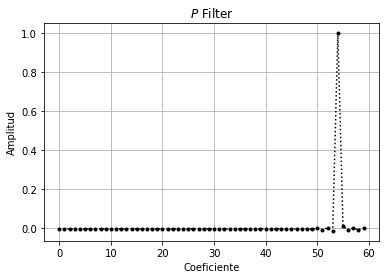

In [11]:
plt.plot(range(60),response[:60]/np.max(response), color= "black", marker='.', linestyle= ':')
plt.xlabel("Coeficiente")
plt.ylabel("Amplitud")
plt.title("$P$ Filter")
plt.grid(which= "both")

Realizo la estimación del filtro $S_2$ con 100000 muestras de ruido blanco gaussiano. Esto lo hago enviando al parlante las muestras de ruido blanco gaussiano y midiendo cuanto mide el microfono de error.


In [12]:
filter_size = 60
# 1ro Envio al parlante Ruido Blanco gaussiano y mido cuando me mide el error mic
muestras = 50000
wgn = np.random.randn(muestras)
error_mic = s2.applyFilter(wgn)
s2_estimation = AdaptativeFilterRLS(60)
# Obtengo la estimacion del filtro S2
error_simulacion, _, __ = s2_estimation.fit(wgn, error_mic)

Aca se observa como el filtro estimó perfectamente los primeros 4 elementos del filtro $S_2$

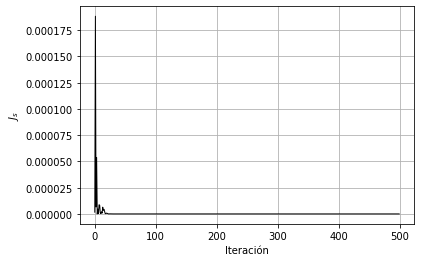

In [13]:
plt.plot(np.power(np.abs(error_simulacion[:500]),2)[0:10000],color= "black", linewidth = 1)
plt.xlabel("Iteración")
plt.ylabel("$J_s$")
plt.grid(which= "both");

#### Obtengo la señal de entrada al sistema

In [14]:
fs, x = wav.read("/content/drive/Shared drives/PASA/TP LMS/Sonidos/airplaneinterior.wav")
x = x / np.max(np.abs(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  """Entry point for launching an IPython kernel.


Aca se puede observar como es la señal de entrada, como se puede ver es una señal muy ruidosa.

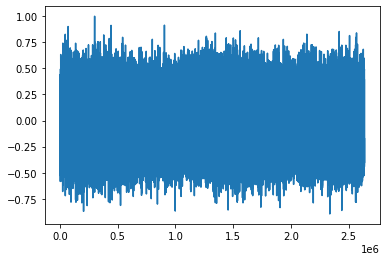

In [15]:
plt.plot(x);

In [16]:
Audio(x, rate=fs)

Output hidden; open in https://colab.research.google.com to view.

Creo mi filtro adaptativo

In [17]:
adapt_filter = AdaptativeFilterRLS(filter_size)

A partir del siguiente diagrama, procedo a realizar el camino correspondiente.

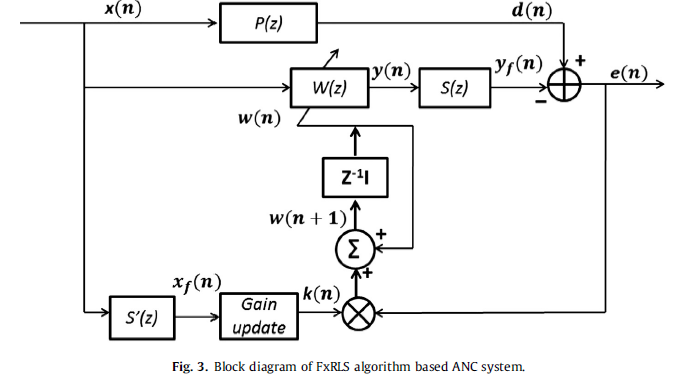

Primero obtengo la señal deseada

In [18]:
desired = p.applyFilter(x)

Despues obtengo la señal $x'(n)$

In [19]:
x_prim = s2_estimation.applyFilterFull(x)
x_s2 = s2.applyFilter(x)

In [20]:
w_out = list(np.zeros(filter_size))
xp_vector = list(np.zeros(filter_size))
error = []
y = []

Simulo tap a tap el sistema:

In [21]:
output = []
error = []
#Simualación de ANC adaptativo
for i in tqdm(range(len(x)-filter_size)):
  inp = x[i:filter_size+i] #Tomamos un cantidad filter_size de muestras
  inp_prim = x_prim[i:filter_size+i]
  x_s2_prim = x_s2[i:filter_size+i]
  des = desired[filter_size+i]
  filter_coefs = adapt_filter.getFilterParameters()
  e_tap = des - np.dot(np.transpose(filter_coefs), np.flip(inp_prim))
  adapt_filter.fitFXRLS(inp_prim, e_tap)
  error.append(e_tap)
  output.append(-np.dot(np.transpose(filter_coefs), inp))


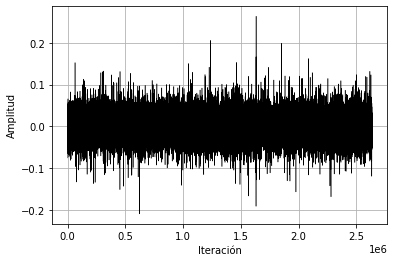

In [22]:
plt.plot(error, linewidth= 0.5, color= "black")
plt.xlabel("Iteración")
plt.ylabel("Amplitud")
plt.grid()

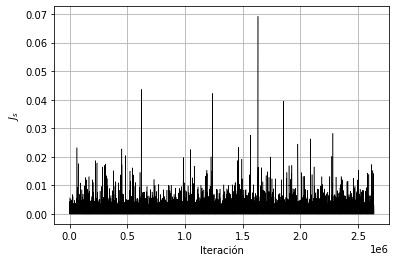

In [23]:
plt.plot(np.power(error,2), linewidth= 0.5, color= "black")
plt.xlabel("Iteración")
plt.ylabel("$J_s$")
plt.grid()

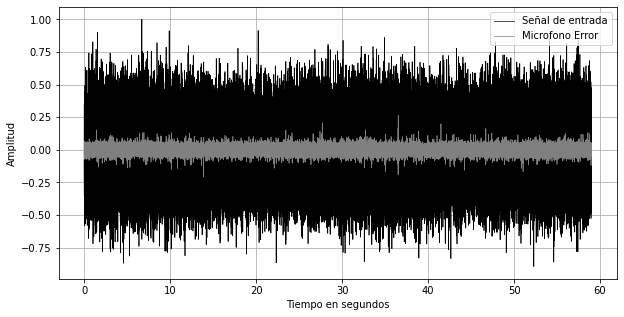

In [24]:
input = x[5:]
t = np.linspace(0,len(error)//fs,fs*len(error)//fs)
plt.figure(figsize=(10,5))
plt.plot(t[:len(input)],input[0:len(error)],linewidth= 0.7, color= "black", label= "Señal de entrada")
plt.plot(t,error, linewidth= 0.7, color= "grey", label= "Microfono Error")
plt.grid(which= "both")
plt.legend(loc= 'upper right')
plt.xlabel("Tiempo en segundos")
plt.ylabel("Amplitud")
plt.show()

### Resultados

Acá se puede escuchar la salida de nuestro sistema, es decir, lo que escucharíamos si tuvieramos estos hipotéticos auriculares puestos.

In [25]:
Audio(np.array(error).flatten(), rate=fs)

Output hidden; open in https://colab.research.google.com to view.